In [1]:
import numpy as np
import agent
import environment
import matplotlib.pyplot as plt

In [2]:
from importlib import reload
# to change the modules and reload them updated
reload(agent)
reload(environment)

<module 'environment' from '/home/nicola/Nicola_unipd/QuintoAnno/Neural Networks/Lab/GitLab/Lab_06/environment.py'>

In [25]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point 
discount = 1.-1./episode_length      # exponential discount factor
softmax = True         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
R0 = 0

Changes made: 
1. Consider a discount factor of $\delta = 1 - \frac{1}{T}$, where T is the length of an episode. This is equivalent to consider future payoffs without discount in T-1 out of T cases and equal to 0 in just 1 out of T cases (that is the case when the episode ends).
2. Introduced a baseline negative reward for actions. This can be thought as a punishment for an agent that decides to stay still and it would be useful especially in cases where the episode ends when the agent reaches the goal (because there is a just a single positive reward in the entire episode, so to maximize the reward it has to reach the goal as soon as possible).

In [26]:
#alpha = np.ones(episodes) * 0.25
#epsilon = np.linspace(0.8, 0.01, episodes)

EPS_START = 0.8
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-2 at the last epoch
epsilon = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/episodes), np.arange(0,episodes+1))))

ALPHA_START = 1
a = ALPHA_START # starting value of alpha
# generate an adaptive learning rate, calibrated in order to have alpha = 10^-1 at the last epoch
alpha = np.array(list(map(lambda i : a*np.exp(-i*1*np.log(10)/episodes), np.arange(0,episodes+1))))

Changes made:

Exponential decaying schedule both for the exploration factor $\epsilon$ and the learning rate $\alpha$, in order to train fast and get a stable result.  

In [27]:
# initialize the agent
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

In [28]:
def train_agent(learner, alpha, epsilon, R0, episodes=2000, episode_length=50,
                x = 10, y = 10, goal = [0, 3], verbose = False, print_every=10):
    reward_log = []
    # perform the training
    for index in range(0, episodes):
        # start from a random state
        initial = [np.random.randint(0, x), np.random.randint(0, y)]
        # initialize environment
        state = initial
        env = environment.Environment(x, y, state, goal, R0)
        reward = 0
        # run episode
        for step in range(0, episode_length):
            # find state index
            state_index = state[0] * y + state[1]
            # choose an action
            action = learner.select_action(state_index, epsilon[index])
            # the agent moves in the environment
            result = env.move(action)
            # Q-learning update
            next_index = result[0][0] * y + result[0][1]
            learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
            # update state and reward
            reward += result[1]
            state = result[0]
        reward /= episode_length
        if verbose:
            if (index+1) % print_every == 0:
                print("Average reward of %.3f at episode %d"%(reward,index+1))
        reward_log.append(reward)
    return learner, reward_log

In [29]:
learner, reward_log = train_agent(learner, alpha, epsilon, R0, verbose=True)

Average reward of 0.000 at episode 10
Average reward of -0.040 at episode 20
Average reward of -0.020 at episode 30
Average reward of -0.080 at episode 40
Average reward of 0.000 at episode 50
Average reward of -0.020 at episode 60
Average reward of -0.040 at episode 70
Average reward of 0.520 at episode 80
Average reward of -0.040 at episode 90
Average reward of -0.040 at episode 100
Average reward of 0.440 at episode 110
Average reward of 0.640 at episode 120
Average reward of 0.200 at episode 130
Average reward of 0.380 at episode 140
Average reward of 0.640 at episode 150
Average reward of 0.500 at episode 160
Average reward of 0.640 at episode 170
Average reward of 0.520 at episode 180
Average reward of 0.700 at episode 190
Average reward of 0.520 at episode 200
Average reward of 0.640 at episode 210
Average reward of 0.420 at episode 220
Average reward of 0.680 at episode 230
Average reward of 0.800 at episode 240
Average reward of 0.840 at episode 250
Average reward of 0.700 at 

In [30]:
# save everything about a simulation
learner_dict = dict(discount=discount, softmax=softmax, sarsa=sarsa)
training_dict = dict(alpha=alpha, epsilon=epsilon)
env_dict = dict(episodes=episodes, episode_length=episode_length, x=x, y=y, goal=goal) 
reward_dict = dict(reward_log=reward_log)
simulation = [learner_dict, training_dict, env_dict, reward_dict]
window = 50
mean_rewardQ = [np.mean(reward_logQ[i*window:(i+1)*window]) for i in range(int(len(reward_logQ)/window))]

In [31]:
np.save("Results/Q_soft_d098_exp_alpha_eps", simulation)

# Analysis

## Q-learning

In [88]:
# load and unpack
simulation_b = np.load("Results/initial_Q-learning.npy", allow_pickle=True) # basic
simulation_s = np.load("Results/initial_Q_soft.npy", allow_pickle=True) # basic+softmax
simulation_f = np.load("Results/Q_soft_d098_exp_alpha_eps.npy", allow_pickle=True) # final configuration

[learner_dict_b, training_dict_b, env_dict_b, reward_dict_b] = simulation_b
[learner_dict_s, training_dict_s, env_dict_s, reward_dict_s] = simulation_s
[learner_dict_s, training_dict_f, env_dict_f, reward_dict_f] = simulation_f

reward_logQ_b = reward_dict_b['reward_log']
reward_logQ_s = reward_dict_s['reward_log']
reward_logQ_f = reward_dict_f['reward_log']

window = 50
T = int(len(reward_logQ_b)/window)
n_episodes2 = np.arange(T)*window

mean_rewardQ_b = [np.mean(reward_logQ_b[i*window:(i+1)*window]) for i in range(T)]
mean_rewardQ_s = [np.mean(reward_logQ_s[i*window:(i+1)*window]) for i in range(T)]
mean_rewardQ_f = [np.mean(reward_logQ_f[i*window:(i+1)*window]) for i in range(T)]

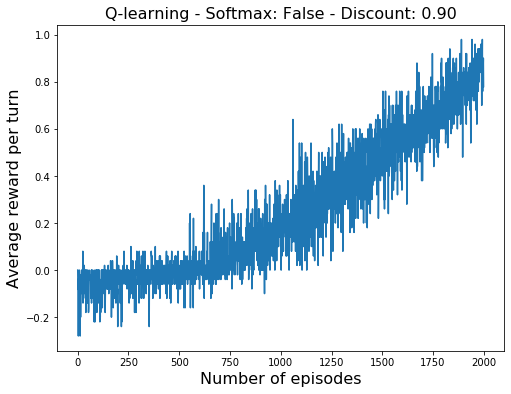

In [89]:
n_episodes = np.arange(len(reward_logQ_b))
plt.figure(figsize = (8,6))
plt.plot(n_episodes, reward_logQ_b)
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Average reward per turn", fontsize=16)
if learner_dict_b['sarsa']:
    plt.title("SARSA learning - Softmax: %r - Discount: %.2f"%(learner_dict_b['softmax'],learner_dict_b['discount']), fontsize=16)
else:
    plt.title("Q-learning - Softmax: %r - Discount: %.2f"%(learner_dict_b['softmax'],learner_dict_b['discount']), fontsize=16)

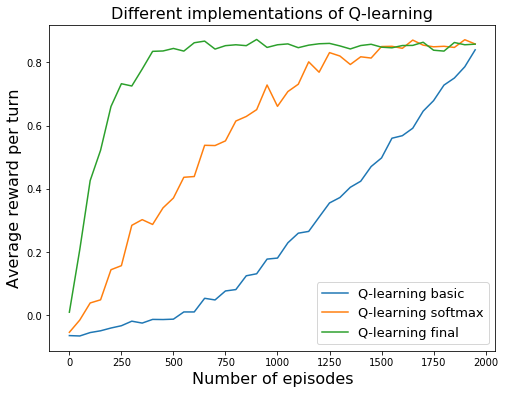

In [98]:
plt.figure(figsize = (8,6))
plt.plot(n_episodes2, mean_rewardQ_b, label = 'Q-learning basic')
plt.plot(n_episodes2, mean_rewardQ_s, label = 'Q-learning softmax')
plt.plot(n_episodes2, mean_rewardQ_f, label = 'Q-learning final')
plt.legend(fontsize=13)
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Average reward per turn", fontsize=16)
plt.title("Different implementations of Q-learning", fontsize=16)
plt.show()

## SARSA

In [92]:
# load and unpack
simulation_b = np.load("Results/initial_SARSA.npy", allow_pickle=True) # basic
simulation_s = np.load("Results/initial_SARSA_soft.npy", allow_pickle=True) # basic+softmax
simulation_f = np.load("Results/SARSA_soft_d098_exp_alpha_eps.npy", allow_pickle=True) # final configuration

[learner_dict_b, training_dict_b, env_dict_b, reward_dict_b] = simulation_b
[learner_dict_s, training_dict_s, env_dict_s, reward_dict_s] = simulation_s
[learner_dict_s, training_dict_f, env_dict_f, reward_dict_f] = simulation_f

reward_logS_b = reward_dict_b['reward_log']
reward_logS_s = reward_dict_s['reward_log']
reward_logS_f = reward_dict_f['reward_log']

window = 50
T = int(len(reward_logS_b)/window)
n_episodes2 = np.arange(T)*window

mean_rewardS_b = [np.mean(reward_logS_b[i*window:(i+1)*window]) for i in range(T)]
mean_rewardS_s = [np.mean(reward_logS_s[i*window:(i+1)*window]) for i in range(T)]
mean_rewardS_f = [np.mean(reward_logS_f[i*window:(i+1)*window]) for i in range(T)]

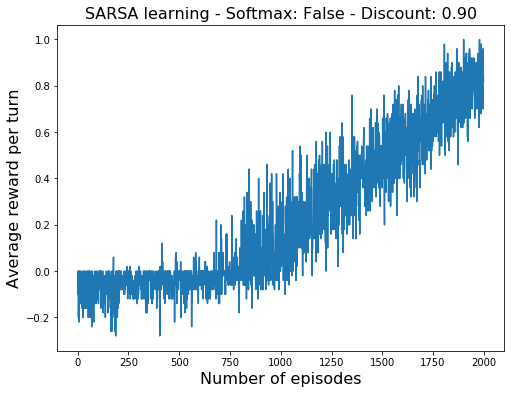

In [83]:
n_episodes = np.arange(len(reward_logS))
plt.figure(figsize = (8,6))
plt.plot(n_episodes, reward_logS)
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Average reward per turn", fontsize=16)
if learner_dict['sarsa']:
    plt.title("SARSA learning - Softmax: %r - Discount: %.2f"%(learner_dict['softmax'],learner_dict['discount']), fontsize=16)
else:
    plt.title("Q-learning - Softmax: %r - Discount: %.2f"%(learner_dict['softmax'],learner_dict['discount']), fontsize=16)

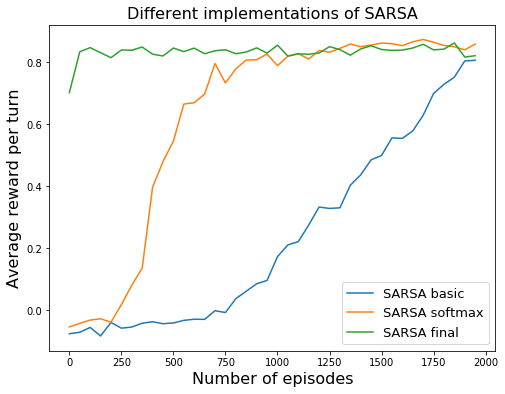

In [99]:
plt.figure(figsize = (8,6))
plt.plot(n_episodes2, mean_rewardS_b, label = 'SARSA basic')
plt.plot(n_episodes2, mean_rewardS_s, label = 'SARSA softmax')
plt.plot(n_episodes2, mean_rewardS_f, label = 'SARSA final')
plt.legend(fontsize=13)
plt.title("Different implementations of SARSA", fontsize=16)
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Average reward per turn", fontsize=16)
plt.show()

## Confronting the two

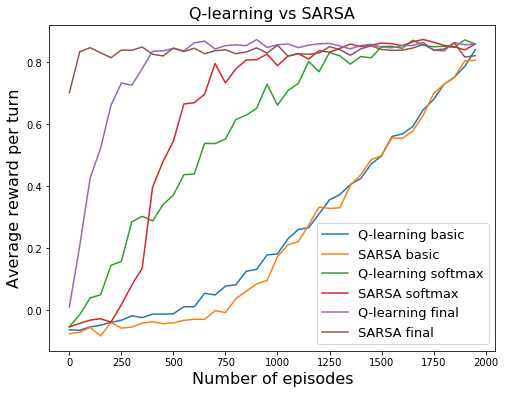

In [96]:
plt.figure(figsize = (8,6))
plt.plot(n_episodes2, mean_rewardQ_b, label = 'Q-learning basic')
plt.plot(n_episodes2, mean_rewardS_b, label = 'SARSA basic')
plt.plot(n_episodes2, mean_rewardQ_s, label = 'Q-learning softmax')
plt.plot(n_episodes2, mean_rewardS_s, label = 'SARSA softmax')
plt.plot(n_episodes2, mean_rewardQ_f, label = 'Q-learning final')
plt.plot(n_episodes2, mean_rewardS_f, label = 'SARSA final')
plt.legend(fontsize=13)
plt.title("Q-learning vs SARSA", fontsize=16)
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Average reward per turn", fontsize=16)
plt.show()

# Value map and rendering

A value map is a useful and simple way to visualize what an agent has learned. The idea is to take the Q-values table, for each state choose the best action (optimal/greedy policy) and that is the expected return from the episode for being in a given state. 

Notice that for the goal cell, that value is equal to the reward of a single turn for staying in that cell multiplied by the number of turns.



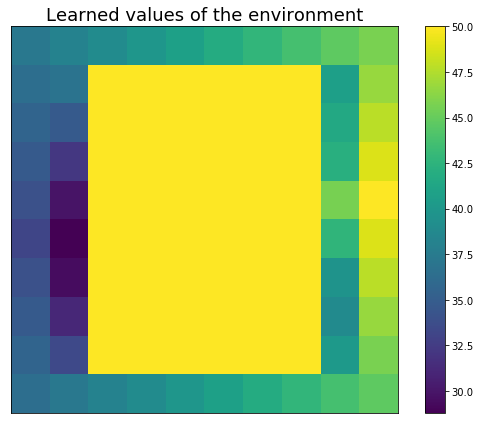

In [126]:
%matplotlib inline
value_map = learner.qtable.max(axis=1)
plt.figure(figsize=(8,6))
plt.imshow(value_map.reshape(x,y))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Learned values of the environment", fontsize=18)
plt.tight_layout()
plt.show()

The rendering instead shows the actual movements of an agent from the initial position untill when it reaches the goal (then it's interrupted because it's kind of boring to see it still).

I usually use red pixel for the agent, white for the goal and custom colors to highlight the different regions of the environment (sometimes it's just to make it a bit more comprehensible).

<IPython.core.display.Javascript object>


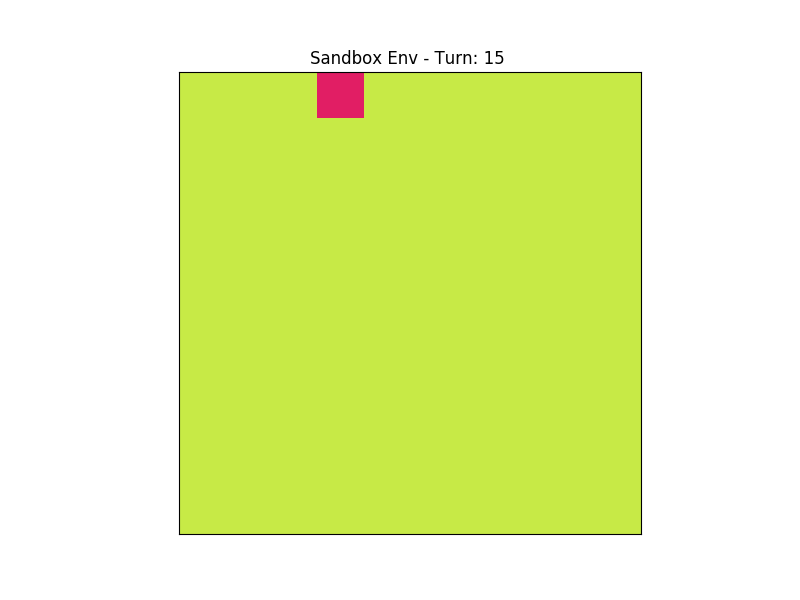

In [11]:
import time
%matplotlib notebook
save = True
index = -1
fig = plt.figure(figsize = (8,6))
initial = [9,9]
# initialize environment
state = initial
goal = np.array([0,3])
env = environment.Environment(x, y, state, goal, R0)
reward = 0

# 
rgb_map = np.full((x,y,3), [199,234,70])/255.
rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
rgb_map[initial[0],initial[1],:] = np.array([225,30,100])/255.
plt.imshow(rgb_map) # show map
plt.title("Sandbox Env - Turn: %d"%(0))
plt.yticks([])
plt.xticks([])
fig.show()
time.sleep(0.75) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif/turn%.3d.png'%0)
    
# run episode
for step in range(0, episode_length):
    # find state index
    state_index = state[0] * y + state[1]
    # choose an action
    action = learner.select_action(state_index, epsilon[index])
    # the agent moves in the environment
    result = env.move(action)
    # Q-learning update
    next_index = result[0][0] * y + result[0][1]
    learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
    # update state and reward
    reward += result[1]
    state = result[0]
    
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    rgb_map = np.full((x,y,3), [199,234,70])/255.
    rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
    rgb_map[state[0],state[1],:] = np.array([225,30,100])/255.
    plt.imshow(rgb_map)
    plt.title("Sandbox Env - Turn: %d "%(step+1))
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    time.sleep(0.75) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/turn%.3d.png'%(step+1))
        
    if state[0] == goal[0] and state[1] == goal[1]:
        break
    


In [12]:
import os
filenames = os.listdir('.raw_gif') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)

In [13]:
# ! pip install imageio
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif/'+filename))
imageio.mimsave('play_episode.gif', images, duration=0.75) # make gif

<img src="gifs/play_episode.gif">

# Different environments

## Seaside

In [108]:
def train_agent_seaside(learner, alpha, epsilon, R0, episodes=2000, episode_length=50,
                x = 10, y = 10, goal = [9, 9], verbose = False, print_every=10):
    reward_log = []
    # perform the training
    for index in range(0, episodes):
        # start from a random state
        initial = [0,0]
        # initialize environment
        state = initial
        env = environment.SeasideEnv(x, y, state, goal, R0)
        reward = 0
        # run episode
        for step in range(0, episode_length):
            # find state index
            state_index = state[0] * y + state[1]
            # choose an action
            action = learner.select_action(state_index, epsilon[index])
            # the agent moves in the environment
            result = env.move(action)
            # Q-learning update
            next_index = result[0][0] * y + result[0][1]
            learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
            # update state and reward
            reward += result[1]
            state = result[0]
        reward /= episode_length
        if verbose:
            if (index+1) % print_every == 0:
                print("Average reward of %.3f at episode %d"%(reward,index+1))
        reward_log.append(reward)
    return learner, reward_log

In [128]:
episodes = 1000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point 
discount = 1.-1./episode_length      # exponential discount factor
softmax = True         # set to true to use Softmax policy
sarsa = True           # set to true to use the Sarsa algorithm
R0 = -0.1

In [129]:
# TODO alpha and epsilon profile
#alpha = np.ones(episodes) * 0.25
#epsilon = np.linspace(0.8, 0.01, episodes)

EPS_START = 0.8
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilon = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/episodes), np.arange(0,episodes+1))))

ALPHA_START = 1
a = ALPHA_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-2 at the last epoch
alpha = np.array(list(map(lambda i : a*np.exp(-i*1*np.log(10)/episodes), np.arange(0,episodes+1))))

In [130]:
# initialize the agent
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

In [131]:
reload(environment)

<module 'environment' from '/home/nicola/Nicola_unipd/QuintoAnno/Neural Networks/Lab/GitLab/Lab_06/environment.py'>

In [132]:
learner, reward_log = train_agent_seaside(learner, alpha, epsilon, R0, episodes=episodes, verbose=True)

Average reward of -0.376 at episode 10
Average reward of -0.388 at episode 20
Average reward of -0.190 at episode 30
Average reward of -0.360 at episode 40
Average reward of -0.158 at episode 50
Average reward of -0.376 at episode 60
Average reward of -0.286 at episode 70
Average reward of -0.246 at episode 80
Average reward of -0.414 at episode 90
Average reward of -0.296 at episode 100
Average reward of -0.220 at episode 110
Average reward of -0.154 at episode 120
Average reward of -0.212 at episode 130
Average reward of -0.152 at episode 140
Average reward of -0.188 at episode 150
Average reward of -0.190 at episode 160
Average reward of -0.126 at episode 170
Average reward of -0.290 at episode 180
Average reward of -0.234 at episode 190
Average reward of 0.146 at episode 200
Average reward of 0.256 at episode 210
Average reward of 0.452 at episode 220
Average reward of 0.396 at episode 230
Average reward of 0.434 at episode 240
Average reward of 0.502 at episode 250
Average reward 

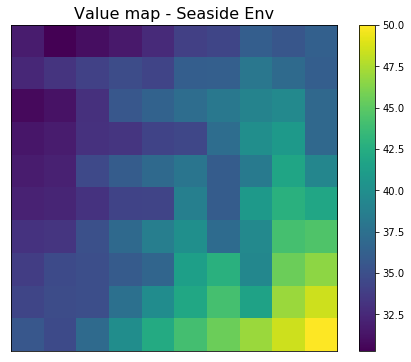

In [139]:
%matplotlib inline
value_map = learner.qtable.max(axis=1).reshape(x,y)
plt.figure(figsize=(8,6))
plt.imshow(value_map)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Value map - Seaside Env", fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


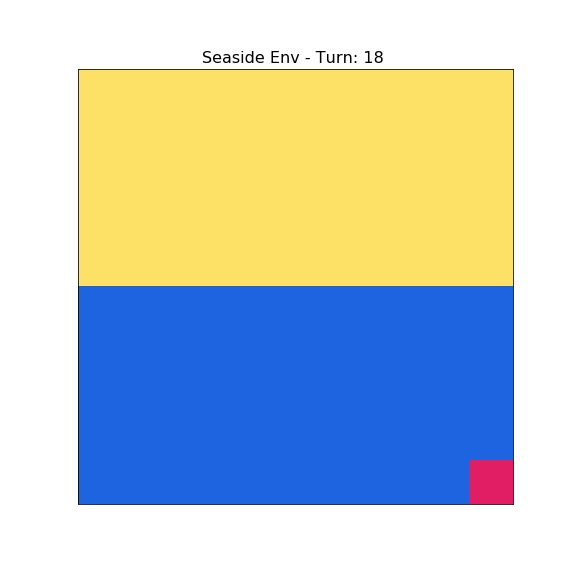

<IPython.core.display.Javascript object>


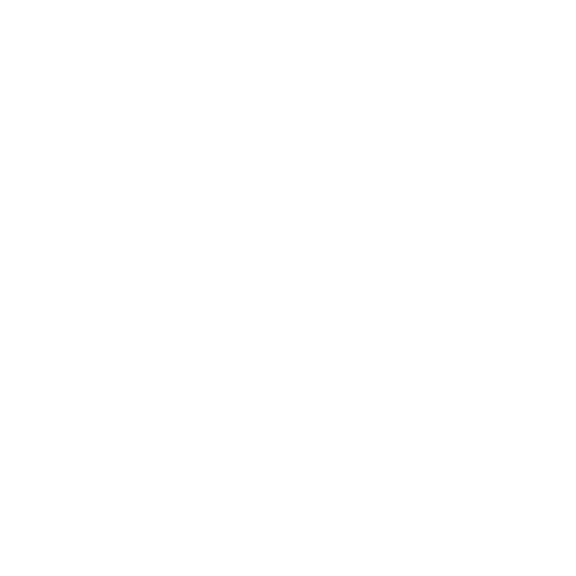

In [137]:
import time
%matplotlib notebook
save = True
index = -1
fig = plt.figure(figsize = (8,8))
initial = [0,0]
# initialize environment
state = initial
goal = np.array([9,9])
env = environment.SeasideEnv(x, y, state, goal, R0)
reward = 0

# 
rgb_map = np.full((x,y,3), [30,100,225])/255.
rgb_map[:5,:,:] = np.array([252, 225, 102])/255.
rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
rgb_map[initial[0],initial[1],:] = np.array([225,30,100])/255.
plt.imshow(rgb_map) # show map
plt.title("Seaside Env - Turn: %d"%(0), fontsize = 16)
plt.yticks([])
plt.xticks([])
fig.show()
time.sleep(0.75) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif/Seaside_turn%.3d.png'%0)
    
# run episode
for step in range(0, episode_length):
    # find state index
    state_index = state[0] * y + state[1]
    # choose an action
    action = learner.select_action(state_index, epsilon[index])
    # the agent moves in the environment
    result = env.move(action)
    # Q-learning update
    next_index = result[0][0] * y + result[0][1]
    learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
    # update state and reward
    reward += result[1]
    state = result[0]
    
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    rgb_map = np.full((x,y,3), [30,100,225])/255.
    rgb_map[:5,:,:] = np.array([252, 225, 102])/255.
    rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
    rgb_map[state[0],state[1],:] = np.array([225,30,100])/255.
    plt.imshow(rgb_map)
    plt.title("Seaside Env - Turn: %d "%(step+1), fontsize = 16)
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    time.sleep(0.75) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/Seaside_turn%.3d.png'%(step+1))
        
    if state[0] == goal[0] and state[1] == goal[1]:
        break
    

In [22]:
filenames = os.listdir('.raw_gif') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif/'+filename))
imageio.mimsave('play_episode_seaside.gif', images, duration=0.75) # make gif

<img src="gifs/play_episode_seaside.gif">

## Two bridges suspended on void 

In [117]:
def train_agent_bridge(learner, alpha, epsilon, R0, episodes=2000, episode_length=50,
                x = 10, y = 10, verbose = False, print_every=10):
    reward_log = []
    # perform the training
    for index in range(0, episodes):
        # start from a random state
        initial = [np.random.randint(x),0]
        # initialize environment
        state = initial
        env = environment.BridgeEnv(x, y, state, R0)
        reward = 0
        # run episode
        for step in range(0, episode_length):
            # find state index
            state_index = state[0] * y + state[1]
            # choose an action
            action = learner.select_action(state_index, epsilon[index])
            # the agent moves in the environment
            result = env.move(action)
            # Q-learning update
            next_index = result[0][0] * y + result[0][1]
            learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
            # update state and reward
            reward += result[1]
            state = result[0]
        reward /= episode_length
        if verbose:
            if (index+1) % print_every == 0:
                print("Average reward of %.3f at episode %d"%(reward,index+1))
        reward_log.append(reward)
    return learner, reward_log

In [118]:
episodes = 500         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box        
discount = 1.-1./episode_length      # exponential discount factor
softmax = True         # set to true to use Softmax policy
sarsa = True           # set to true to use the Sarsa algorithm
R0 = -0.1

In [119]:
EPS_START = 0.8
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilon = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/episodes), np.arange(0,episodes+1))))

ALPHA_START = 1
a = ALPHA_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-2 at the last epoch
alpha = np.array(list(map(lambda i : a*np.exp(-i*1*np.log(10)/episodes), np.arange(0,episodes+1))))

In [120]:
# initialize the agent
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

In [121]:
reload(environment)

<module 'environment' from '/home/nicola/Nicola_unipd/QuintoAnno/Neural Networks/Lab/GitLab/Lab_06/environment.py'>

In [122]:
learner, reward_log = train_agent_bridge(learner, alpha, epsilon, R0, episodes=episodes, verbose=True)

Average reward of -0.568 at episode 10
Average reward of -0.244 at episode 20
Average reward of -0.154 at episode 30
Average reward of -0.208 at episode 40
Average reward of -0.532 at episode 50
Average reward of -0.172 at episode 60
Average reward of -0.172 at episode 70
Average reward of -0.190 at episode 80
Average reward of -0.208 at episode 90
Average reward of -0.370 at episode 100
Average reward of 0.136 at episode 110
Average reward of 0.440 at episode 120
Average reward of 0.440 at episode 130
Average reward of 0.692 at episode 140
Average reward of 0.670 at episode 150
Average reward of 0.520 at episode 160
Average reward of 0.648 at episode 170
Average reward of 0.648 at episode 180
Average reward of 0.626 at episode 190
Average reward of 0.626 at episode 200
Average reward of 0.714 at episode 210
Average reward of 0.670 at episode 220
Average reward of 0.648 at episode 230
Average reward of 0.626 at episode 240
Average reward of 0.604 at episode 250
Average reward of 0.692 

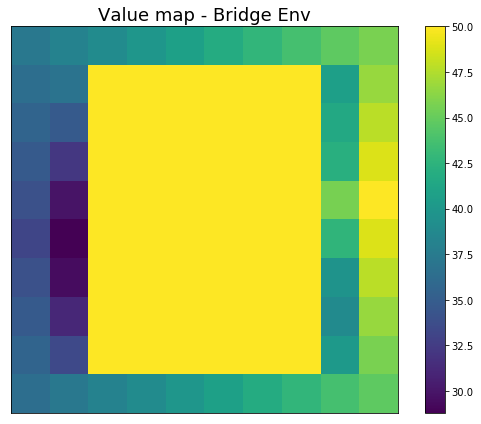

In [127]:
value_map = learner.qtable.max(axis=1).reshape(x,y)
plt.figure(figsize=(8,6))
plt.imshow(value_map)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Value map - Bridge Env", fontsize=18)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


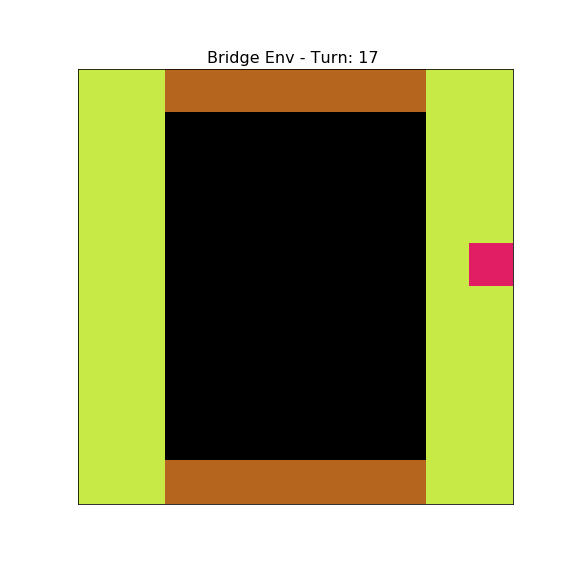

<IPython.core.display.Javascript object>


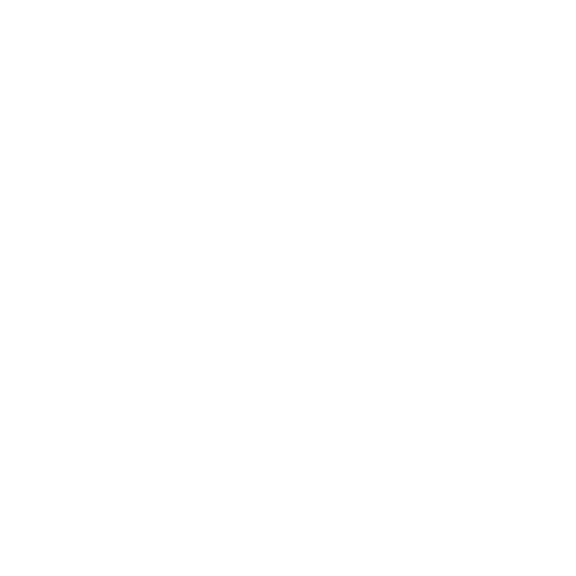

In [124]:
import time
%matplotlib notebook
save = True
index = -1
fig = plt.figure(figsize = (8,8))
initial = [6,0]
# initialize environment
state = initial
goal = np.array([4,9])
env = environment.BridgeEnv(x, y, state, R0)
reward = 0

# 
rgb_map = np.full((x,y,3), [199,234,70])/255.
rgb_map[1:9,2:8,:] = np.array([0, 0, 0])/255.
rgb_map[0,2:8,:] = np.array([181,101,29])/255.
rgb_map[9,2:8,:] = np.array([181,101,29])/255.
rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
rgb_map[initial[0],initial[1],:] = np.array([225,30,100])/255.
plt.imshow(rgb_map) # show map
plt.title("Bridge Env - Turn: %d"%(0), fontsize = 16)
plt.yticks([])
plt.xticks([])
fig.show()
time.sleep(0.75) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif/Bridge_turn%.3d.png'%0)
    
# run episode
for step in range(0, episode_length):
    # find state index
    state_index = state[0] * y + state[1]
    # choose an action
    action = learner.select_action(state_index, epsilon[index])
    # the agent moves in the environment
    result = env.move(action)
    # Q-learning update
    next_index = result[0][0] * y + result[0][1]
    learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
    # update state and reward
    reward += result[1]
    state = result[0]
    
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    rgb_map = np.full((x,y,3), [199,234,70])/255.
    rgb_map[1:9,2:8,:] = np.array([0, 0, 0])/255.
    rgb_map[0,2:8,:] = np.array([181,101,29])/255.
    rgb_map[9,2:8,:] = np.array([181,101,29])/255.
    rgb_map[goal[0],goal[1],:] = np.array([255,255,255])/255.
    rgb_map[state[0],state[1],:] = np.array([225,30,100])/255.
    plt.imshow(rgb_map)
    plt.title("Bridge Env - Turn: %d "%(step+1), fontsize = 16)
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    time.sleep(0.75) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/Bridge_turn%.3d.png'%(step+1))
        
    if state[0] == goal[0] and state[1] == goal[1]:
        break
    

In [134]:
filenames = os.listdir('.raw_gif') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif/'+filename))
imageio.mimsave('play_episode_bridge.gif', images, duration=0.75) # make gif

<img src="gifs/play_episode_bridge.gif">